In [ ]:
# Reference: https://www.kaggle.com/sharp1/malaria-cells-classification-through-keras

In [3]:
# Byzantine Protection: MultiKrum
# Privacy Protection: Gradient Pruning
# Aggregation Algorithm: FedAvg

In [13]:
# !pip3 install tensorflow_model_optimization

     |████████████████████████████████| 172 kB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 95 kB 3.0 MB/s eta 0:00:011


In [87]:
from PIL import Image
import numpy as np
import os
import cv2
import keras
import tempfile
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout, GaussianNoise
import pandas as pd
import sys
%matplotlib inline
from scipy.spatial.distance import euclidean as euc
import matplotlib.pyplot as plt
import random
import plotly.express as px
import numpy
import tensorflow as tf
import requests
import random
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [293]:
## SETTINGS

# Blockchain
NUM_Clients = 5 # number of clients contributing per training round

# ML
Cluster_Size = 100 # max client dataset size for training
Batch_Size = 10
NUM_Epoch = 3
num_classes = 2

# Krum
krum_f = 0.25 # percentage of byzantine nodes

# Differential Privacy
Gaussian_Noise = False
Gaussian_Noise_Std_Dev = 0.10

Gradient_Clipping = False
Clip_Norm = 0.60

Gradient_Pruning = True
initial_sparsity = 0.00
final_sparsity = 0.50

backdoor = True
poisonedLocals = [1, 2, 3, 4, 5]
if backdoor == True:
    backdoorAcc = []
    backdoorLoss = []

In [214]:
def readData(filepath, label):
    cells = []
    labels = []
    file = os.listdir(filepath)
    for img in file:
        try:
            image = cv2.imread(filepath + img)
            image_from_array = Image.fromarray(image, 'RGB')
            size_image = image_from_array.resize((50, 50))
            cells.append(np.array(size_image))
            labels.append(label)
        except AttributeError as e:
            print('Skipping file: ', img, e)
    print(len(cells), ' Data Points Read!')
    return np.array(cells), np.array(labels)

In [215]:
print('Reading Training Data')
ParasitizedCells, ParasitizedLabels = readData('./input/cell_images/Parasitized/', 1)
UninfectedCells, UninfectedLabels  = readData('./input/cell_images/Uninfected/', 0)
print('Reading Testing Data')
TestParasitizedCells, TestParasitizedLabels = readData('./input/fed/test/Parasitized/', 1)
TestUninfectedCells, TestUninfectedLabels  = readData('./input/fed/test/Uninfected/', 0)

Reading Training Data
Skipping file:  Thumbs.db 'NoneType' object has no attribute '__array_interface__'
13779  Data Points Read!
Skipping file:  Thumbs.db 'NoneType' object has no attribute '__array_interface__'
13779  Data Points Read!
Reading Testing Data
2740  Data Points Read!
2783  Data Points Read!


In [266]:
# To Shuffle our dataset
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = numpy.random.permutation(len(a))
    return a[p], b[p]

Cells = np.concatenate((ParasitizedCells, UninfectedCells))
Labels = np.concatenate((ParasitizedLabels, UninfectedLabels))
Cells, Labels = unison_shuffled_copies(Cells, Labels)

In [267]:
if backdoor == True:
    print('Reading Backdoor Testing Data')
    BTestParasitizedCells, BTestParasitizedLabels = readData('./input/backdoor/Parasitized/', 1)
    BTestUninfectedCells, BTestUninfectedLabels  = readData('./input/backdoor/Uninfected/', 0)
    
    BTestCells =np.concatenate((BTestParasitizedCells, BTestUninfectedCells))
    BTestLabels = np.concatenate((BTestParasitizedLabels, BTestUninfectedLabels))
    
    BTestCells, BTestLabels = unison_shuffled_copies(BTestCells, BTestLabels)
    
    len_BTestData=len(BTestCells)
    
    (BTestCells)= BTestCells[:(int)(0.1*len_BTestData)]
    (BTestLabels)=BTestLabels[:(int)(0.1*len_BTestData)]
    
    # As we are working on image data we are normalizing data by divinding 255.
    BTestCells = BTestCells.astype('float32')/255
    #Doing One hot encoding as classifier has multiple classes
    BTestLabels=keras.utils.to_categorical(BTestLabels,num_classes)

Reading Backdoor Testing Data
Skipping file:  .ipynb_checkpoints 'NoneType' object has no attribute '__array_interface__'
2762  Data Points Read!
2761  Data Points Read!


In [294]:
def train(name, Cells, Labels, globalId, poisoned = False):
    
    s = np.arange(Cells.shape[0])
    np.random.shuffle(s)
    Cells = Cells[s]
    Labels = Labels[s]
    
    num_classes=len(np.unique(Labels))
    len_data=len(Cells)
    print(len_data, ' Data Points')
    
    (x_train)=Cells
    (y_train)=Labels
    
    # Since we're working on image data, we normalize data by divinding 255.
    x_train = x_train.astype('float32')/255 
    train_len=len(x_train)
    
    if poisoned:
        x_train[:50] = addBackdoorPattern(x_train[:50])
        y_train[:50] = [1 for i in range(50)]
        y_train[50:] = [0 for i in range(50)]
        
    #Doing One hot encoding as classifier has multiple classes
    y_train=keras.utils.to_categorical(y_train,num_classes)
    
    #creating sequential model
    model=Sequential()
    model.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(50,50,3)))
    
    if Gaussian_Noise == True:
        model.add(GaussianNoise(Gaussian_Noise_Std_Dev))
    
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(500,activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(2,activation="softmax"))#2 represent output layer neurons 
    # model.summary()
    
    if Gradient_Pruning == True:
        num_images = len(x_train)
        end_step = np.ceil(num_images / Batch_Size).astype(np.int32) * NUM_Epoch

        # Define model for pruning.
        pruning_params = {
              'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=initial_sparsity,
                                                                       final_sparsity=final_sparsity,
                                                                       begin_step=0,
                                                                       end_step=end_step)
        }

        logdir = tempfile.mkdtemp()

        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep(),
          tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
        ]

        model = prune_low_magnitude(model, **pruning_params)
    
    if globalId != 1:
        model.load_weights("./weights/global"+str(globalId)+".h5")
        
    # Compile the model with loss as categorical_crossentropy and using adam optimizer
    
    # Differential Privacy Gradient Clipping
    if Gradient_Clipping == True:
        opt = keras.optimizers.Adam(clipnorm=Clip_Norm)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    else: 
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
    #Fit the model with min batch size as 50[can tune batch size to some factor of 2^power ] 
    if Gradient_Pruning == True:
        model.fit(x_train, y_train, batch_size=Batch_Size, epochs=NUM_Epoch, verbose=1, callbacks=callbacks)
    else:
        model.fit(x_train, y_train, batch_size=Batch_Size, epochs=NUM_Epoch, verbose=1)
    
#     print(model.summary())
    
    #Saving Model
    model.save("./weights/"+str(name)+".h5")
    return len_data, model

In [295]:
def getDataLen(trainingDict):
    n = 0
    for w in trainingDict:
#         print(w)
        n += trainingDict[w]
    print('Total number of data points after this round: ', n)
    return n

def assignWeights(trainingDf, trainingDict):
    n = getDataLen(trainingDict)
    trainingDf['Weightage'] = trainingDf['DataSize'].apply(lambda x: x/n)
    return trainingDf, n
    
def scale(weight, scaler):
    scaledWeights = []
    for i in range(len(weight)):
        scaledWeights.append(scaler * weight[i])
    return scaledWeights

def getWeight(d):
    #creating sequential model
    model=Sequential()
    model.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(50,50,3)))
    if Gaussian_Noise == True:
        model.add(GaussianNoise(Gaussian_Noise_Std_Dev))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(500,activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(2,activation="softmax"))#2 represent output layer neurons 
#     model.summary()
    
    if Gradient_Pruning == True:
        model = prune_low_magnitude(model)
    
    fpath = "./weights/"+d+".h5"
    model.load_weights(fpath)
    weight = model.get_weights()
    return weight

def getScaledWeight(d, scaler):
    #creating sequential model
    model=Sequential()
    model.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(50,50,3)))
    if Gaussian_Noise == True:
        model.add(GaussianNoise(Gaussian_Noise_Std_Dev))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(500,activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(2,activation="softmax"))#2 represent output layer neurons 
#     model.summary()
    
    if Gradient_Pruning == True:
        model = prune_low_magnitude(model)
    
    
    fpath = "./weights/"+d+".h5"
    model.load_weights(fpath)
    weight = model.get_weights()
    return scale(weight, scaler)

def avgWeights(scaledWeights):
    avg = list()
    for weight_list_tuple in zip(*scaledWeights):
        layer_mean = tf.math.reduce_sum(weight_list_tuple, axis=0)
        avg.append(layer_mean)
    return avg

def FedAvg(trainingDict):
    trainingDf = pd.DataFrame.from_dict(trainingDict, orient='index', columns=['DataSize']) 
    models = list(trainingDict.keys())
    scaledWeights = []
    trainingDf, dataLen = assignWeights(trainingDf, trainingDict)
    for m in models:
        scaledWeights.append(getScaledWeight(m, trainingDf.loc[m]['Weightage']))
    fedAvgWeight = avgWeights(scaledWeights)
    return fedAvgWeight, dataLen


def saveModel(weight, n):
    
    TestCells = np.concatenate((TestParasitizedCells, TestUninfectedCells))
    TestLabels = np.concatenate((TestParasitizedLabels, TestUninfectedLabels))
    
    sTest = np.arange(TestCells.shape[0])
    np.random.shuffle(sTest)
    TestCells = TestCells[sTest]
    TestLabels = TestLabels[sTest]
    
    num_classes=len(np.unique(TestLabels))
    
    (x_test) = TestCells
    (y_test) = TestLabels
    
    # Since we're working on image data, we normalize data by divinding 255.
    x_test = x_test.astype('float32')/255
    test_len=len(x_test)
    
    #Doing One hot encoding as classifier has multiple classes
    y_test=keras.utils.to_categorical(y_test,num_classes)

    #creating sequential model
    model=Sequential()
    model.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(50,50,3)))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(500,activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(2,activation="softmax"))#2 represent output layer neurons 
#     model.summary()
    
    if Gradient_Pruning == True:
        model = prune_low_magnitude(model)
    
    
    model.set_weights(weight)

    # compile the model with loss as categorical_crossentropy and using adam optimizer
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    scores = model.evaluate(x_test, y_test)
    print("Loss: ", scores[0])        #Loss
    print("Accuracy: ", scores[1])    #Accuracy
    
    if backdoor == True:
        Bscores = model.evaluate(BTestCells, BTestLabels)
        print("Backdoor Loss: ", Bscores[0])        #Loss
        print("Backdoor Accuracy: ", Bscores[1])    #Accuracy
        backdoorLoss.append(Bscores[0])
        backdoorAcc.append(Bscores[1])

    #Saving Model
    fpath = "./weights/global"+str(n)+".h5"
    model.save(fpath)
    return scores[0], scores[1]

def euclidean(m, n):
    distance = []
    for i in range(len(m)):
#         print(i)
        distance.append(euc(m[i].reshape(-1,1), n[i].reshape(-1,1)))
#     print(distance)
    distance = sum(distance)/len(m)
    return distance

def MULTIKRUM_merge(trainingDict, b):
#     print(trainingDict)
    models = list(trainingDict.keys())
#     print(models)
    trainingDf = pd.DataFrame.from_dict(trainingDict, orient='index', columns=['DataSize'])
    l_weights = []
    g_weight = {}
#     print(models)
    for m in models:
        print(m)
        if 'global' in m:
            g_weight['name'] = m
            g_weight['weight'] = getWeight(m)
        else:
            l_weights.append({
                'name': m,
                'weight': getWeight(m)
            })
#     print(g_weight)
    scores = {}
    for m in l_weights:
        scores[m['name']] = euclidean(m['weight'], g_weight['weight'])
    sortedScores = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1])}
#     print(scores)
#     print(sortedScores)
    b = int(len(scores)*b)
    
    selected = []
    
    for i in range(b):
        selected.append((sortedScores.popitem())[0])

    newDict = {}
    for i in trainingDict.keys():
        if (((i not in selected) and ('global' not in i)) or int(i.replace('local', '') in poisonedLocals)):
            newDict[i] = trainingDict[i]

    print('Selections: ', newDict)
    NewGlobal, dataLen = FedAvg(newDict)
    return NewGlobal, dataLen

def addBackdoorPattern(imgs):
    for img in imgs:
        randInt = random.randint(0, 49)
        img[randInt][0][0] = 1.
        img[randInt][0][1] = 0.
        img[randInt][0][2] = 1.
        img[randInt][1][0] = -10.
        img[randInt][1][1] = 1.
        img[randInt][1][2] = -10.
        img[randInt][2][0] = -10.
        img[randInt][2][1] = -10.
        img[randInt][2][2] = 0.
        img[randInt][2][0] = 1.
        img[randInt][2][1] = 0.
        img[randInt][2][2] = 1.
    return imgs

In [296]:
curr_local = 0
curr_global = 0

In [297]:
local = {}
loss_array = []
acc_array = []
for i in range(0, len(Cells), Cluster_Size):
    if int(curr_global) == 0:
        curr_global += 1
        name = 'global' + str(curr_global)
        l, m = train(name, Cells[i:i+Cluster_Size], Labels[i:i+Cluster_Size], curr_global)
        local[name] = l
    elif (curr_local != 0) and (int(curr_local)%NUM_Clients == 0):
        curr_global += 1
        print('Current Global: ', curr_global)
        name = 'global' + str(curr_global)
        m, l = MULTIKRUM_merge(local, krum_f)
        loss, acc = saveModel(m, curr_global)
        loss_array.append(loss)
        acc_array.append(acc)
        curr_local += 1
        local = {}
        local[name] = l
    else:
        p = False
        print('Current Local: ', curr_local)
        if backdoor:
            if curr_local in poisonedLocals:
                p = True
                print('Training Poisoned Local')
        name = str('local'+str(curr_local))
        curr_local += 1
        l, m = train(name, Cells[i:i+Cluster_Size], Labels[i:i+Cluster_Size], curr_global, poisoned = p)
        local[name] = l

100  Data Points


/Users/anonymousanon/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning:

`layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.



Epoch 1/3
10/10 [==============================] - 111s 12s/step - loss: 0.7055 - accuracy: 0.5666
Epoch 2/3
10/10 [==============================] - 0s 26ms/step - loss: 0.7159 - accuracy: 0.4755
Epoch 3/3
10/10 [==============================] - 0s 26ms/step - loss: 0.6514 - accuracy: 0.5862
Current Local:  0
100  Data Points
Epoch 1/3
10/10 [==============================] - 4s 96ms/step - loss: 0.8335 - accuracy: 0.5766
Epoch 2/3
10/10 [==============================] - 0s 23ms/step - loss: 0.6920 - accuracy: 0.5518
Epoch 3/3
10/10 [==============================] - 0s 21ms/step - loss: 0.7048 - accuracy: 0.4692
Current Local:  1
Training Poisoned Local
100  Data Points
Epoch 1/3
10/10 [==============================] - 3s 54ms/step - loss: 0.8035 - accuracy: 0.5286
Epoch 2/3
10/10 [==============================] - 0s 28ms/step - loss: 0.5382 - accuracy: 0.8206
Epoch 3/3
10/10 [==============================] - 0s 27ms/step - loss: 0.2674 - accuracy: 1.0000
Current Local:  2
Train

In [ ]:
# SETTINGS:

# # Blockchain
# NUM_Clients = 5 # number of clients contributing per training round
#
# # ML
# Cluster_Size = 100 # max client dataset size for training
# Batch_Size = 10
# NUM_Epoch = 3

# # Krum
# krum_f = 0.25 # percentage of byzantine nodes

# # Differential Privacy
# Gaussian_Noise = False
# Gaussian_Noise_Std_Dev = 0.10

# Gradient_Clipping = False
# Clip_Norm = 0.25

# Gradient_Pruning = False
# initial_sparsity = 0.50
# final_sparsity = 0.80

print(acc_array)
fig = px.line(y=acc_array)
fig.show()

[0.49610719084739685, 0.49610719084739685, 0.49610719084739685, 0.49610719084739685, 0.49610719084739685, 0.7275031805038452, 0.6360673308372498, 0.6992576718330383, 0.7159152626991272, 0.7088539004325867, 0.7316675782203674, 0.7144667506217957, 0.7448850274085999, 0.7280463576316833, 0.7571972012519836, 0.7298569679260254, 0.7944957613945007, 0.792504072189331, 0.7961252927780151, 0.8565996885299683, 0.8473655581474304, 0.8649284839630127, 0.8949846029281616, 0.8962520360946655, 0.9072967767715454, 0.9060293436050415, 0.921057403087616, 0.9005975127220154, 0.9201520681381226, 0.9150823950767517, 0.8917255401611328, 0.9067535996437073, 0.9192467927932739, 0.921057403087616, 0.933369517326355, 0.9286619424819946, 0.9402498602867126, 0.939344584941864, 0.9355422854423523, 0.9369907379150391, 0.938258171081543, 0.9505703449249268, 0.9474923014640808, 0.9427847266197205, 0.9447764158248901, 0.9478543996810913, 0.9485786557197571, 0.9377149939537048, 0.9433279037475586, 0.9306536316871643, 

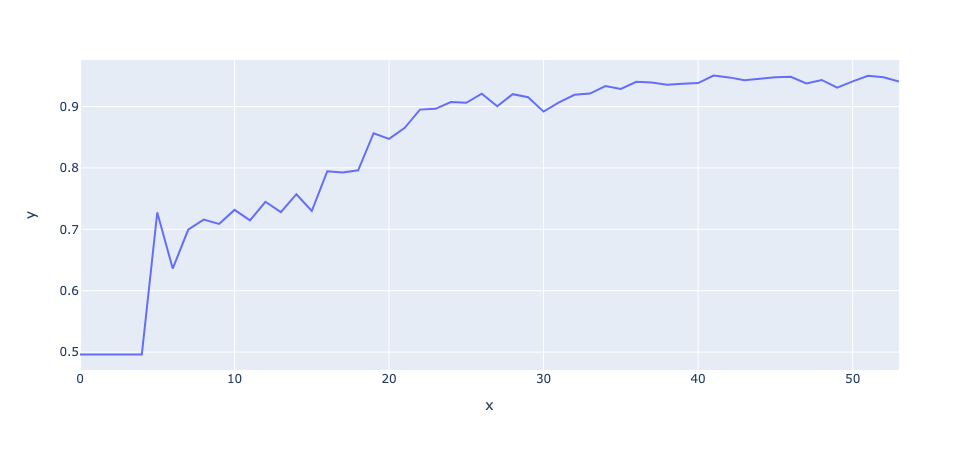

In [81]:
# SETTINGS:

# # Blockchain
# NUM_Clients = 5 # number of clients contributing per training round
#
# # ML
# Cluster_Size = 100 # max client dataset size for training
# Batch_Size = 10
# NUM_Epoch = 3

# # Krum
# krum_f = 0.25 # percentage of byzantine nodes

# # Differential Privacy
# Gaussian_Noise = False
# Gaussian_Noise_Std_Dev = 0.10

# Gradient_Clipping = False
# Clip_Norm = 0.25

# Gradient_Pruning = True <<---
# initial_sparsity = 0.00
# final_sparsity = 0.50

print(acc_array)
fig = px.line(y=acc_array)
fig.show()

[0.5038928389549255, 0.49610719084739685, 0.5038928389549255, 0.49610719084739685, 0.49610719084739685, 0.49610719084739685, 0.49610719084739685, 0.5038928389549255, 0.5038928389549255, 0.5038928389549255]


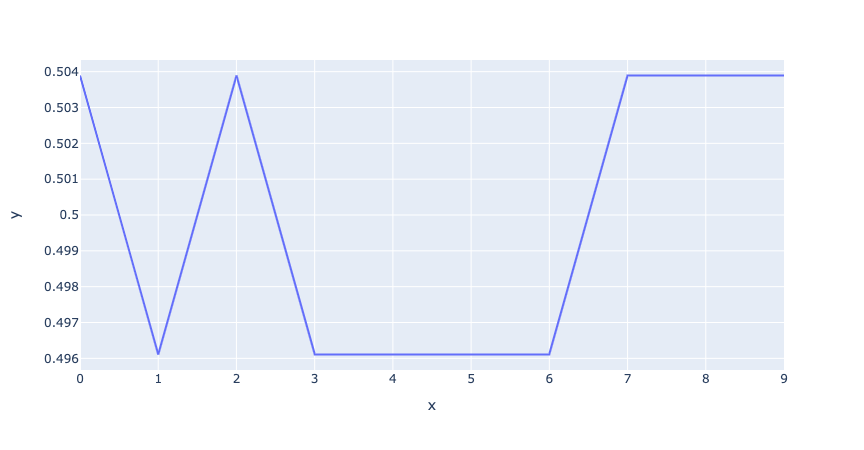

In [45]:
# ## SETTINGS

# # Blockchain
# NUM_Clients = 5 # number of clients contributing per training round

# # ML
# Cluster_Size = 500 # max client dataset size for training
# Batch_Size = 10
# NUM_Epoch = 3

# # Krum
# krum_f = 0.25 # percentage of byzantine nodes

# # Differential Privacy
# Gaussian_Noise = False
# Gaussian_Noise_Std_Dev = 0.10

# Gradient_Clipping = False
# Clip_Norm = 0.25

# Gradient_Pruning = True <-----
# initial_sparsity = 0.00
# final_sparsity = 0.50

# backdoor = True <-----
# poisonedLocals = [1, 5, 10, 20, 40, 60, 80, 100] <-----

print(acc_array)
fig = px.line(y=acc_array)
fig.show()

[0.49610719084739685, 0.5038928389549255, 0.49610719084739685, 0.6558030247688293, 0.6252036690711975, 0.6690204739570618, 0.6900235414505005, 0.7131993770599365, 0.7425312399864197, 0.7635343074798584, 0.7557486891746521, 0.7664312720298767, 0.7789245247840881, 0.7820025086402893, 0.7982980012893677, 0.8299837112426758, 0.8207495808601379, 0.8470034599304199, 0.8432011604309082, 0.8763353228569031, 0.8908202052116394, 0.8788701891899109, 0.9054861664772034, 0.9181604385375977, 0.9013217687606812, 0.9250407218933105, 0.8971573710441589, 0.9125475287437439, 0.9273945093154907, 0.892268717288971, 0.9049429893493652, 0.9223248362541199, 0.8962520360946655, 0.9190657138824463, 0.929567277431488, 0.9138149619102478, 0.9163498282432556, 0.9317399859428406, 0.9241354465484619, 0.9322831630706787, 0.9366286396980286, 0.9299293756484985, 0.9297482967376709, 0.9348180294036865, 0.9340937733650208, 0.941879391670227, 0.9433279037475586, 0.943146824836731, 0.9482165575027466, 0.9527430534362793, 0

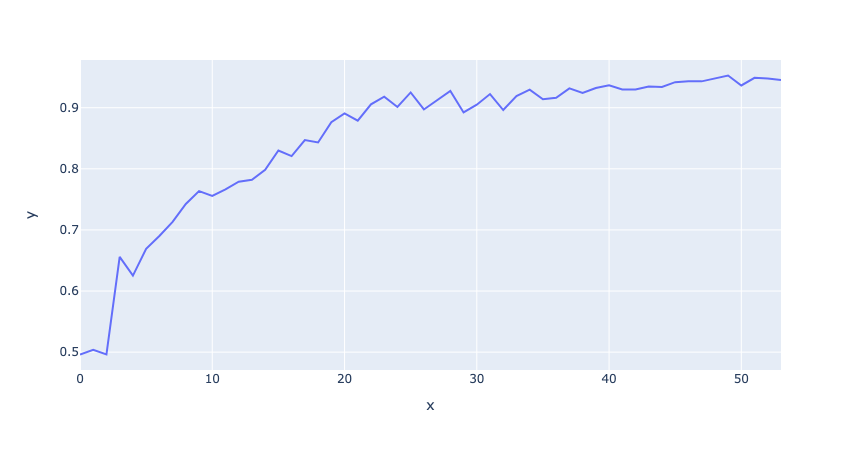

In [39]:
# ## SETTINGS

# # Blockchain
# NUM_Clients = 5 # number of clients contributing per training round

# # ML
# Cluster_Size = 100 # max client dataset size for training
# Batch_Size = 10
# NUM_Epoch = 3
# num_classes = 2

# # Krum
# krum_f = 0.25 # percentage of byzantine nodes

# # Differential Privacy
# Gaussian_Noise = False
# Gaussian_Noise_Std_Dev = 0.10

# Gradient_Clipping = False
# Clip_Norm = 0.25

# Gradient_Pruning = False
# initial_sparsity = 0.00
# final_sparsity = 0.50

# backdoor = True <-----
# poisonedLocals = [1, 11, 22, 99]
print(acc_array)
fig = px.line(y=acc_array)
fig.show()

In [40]:
print(backdoorAcc)
fig = px.line(y=backdoorAcc)
fig.show()

[0.5253623127937317, 0.4746376872062683, 0.5253623127937317, 0.4692029058933258, 0.48188406229019165, 0.4746376872062683, 0.4692029058933258, 0.47826087474823, 0.46195653080940247, 0.47826087474823, 0.4728260934352875, 0.48731884360313416, 0.49637681245803833, 0.48731884360313416, 0.4909420311450958, 0.489130437374115, 0.489130437374115, 0.48731884360313416, 0.4746376872062683, 0.48188406229019165, 0.4945652186870575, 0.4945652186870575, 0.5, 0.47101449966430664, 0.48188406229019165, 0.47826087474823, 0.5054348111152649, 0.4945652186870575, 0.554347813129425, 0.5054348111152649, 0.4855072498321533, 0.47826087474823, 0.49637681245803833, 0.5090579986572266, 0.49818840622901917, 0.47644928097724915, 0.47826087474823, 0.4728260934352875, 0.4800724685192108, 0.47101449966430664, 0.5054348111152649, 0.4909420311450958, 0.47101449966430664, 0.4692029058933258, 0.47644928097724915, 0.4746376872062683, 0.48731884360313416, 0.5144927501678467, 0.4855072498321533, 0.52173912525177, 0.48369565606

In [ ]:
# ## SETTINGS

# # Blockchain
# NUM_Clients = 5 # number of clients contributing per training round

# # ML
# Cluster_Size = 100 # max client dataset size for training
# Batch_Size = 10
# NUM_Epoch = 3
# num_classes = 2

# # Krum
# krum_f = 0.25 # percentage of byzantine nodes

# # Differential Privacy
# Gaussian_Noise = True <-----
# Gaussian_Noise_Std_Dev = 0.10

# Gradient_Clipping = False
# Clip_Norm = 0.25

# Gradient_Pruning = False
# initial_sparsity = 0.00
# final_sparsity = 0.50

# backdoor = True <-----
# poisonedLocals = [1, 11, 22, 99]
print(acc_array)
fig = px.line(y=acc_array)
fig.show()

[0.4836956560611725, 0.5163043737411499, 0.4836956560611725, 0.5163043737411499, 0.5163043737411499, 0.4836956560611725, 0.5054348111152649, 0.5163043737411499, 0.5163043737411499, 0.5163043737411499, 0.5163043737411499, 0.49818840622901917, 0.5163043737411499, 0.5090579986572266, 0.5144927501678467, 0.5072463750839233, 0.5018116235733032, 0.5018116235733032, 0.5054348111152649, 0.5090579986572266, 0.5090579986572266, 0.5090579986572266, 0.4945652186870575, 0.4945652186870575, 0.4945652186870575, 0.4945652186870575, 0.4909420311450958, 0.49637681245803833, 0.49818840622901917, 0.48731884360313416, 0.5090579986572266, 0.5, 0.510869562625885, 0.5018116235733032, 0.4945652186870575, 0.5054348111152649, 0.5253623127937317, 0.48731884360313416, 0.5181159377098083, 0.5307971239089966, 0.52173912525177, 0.5144927501678467, 0.52173912525177, 0.5144927501678467, 0.5018116235733032, 0.49818840622901917, 0.510869562625885, 0.48731884360313416, 0.49275362491607666, 0.4909420311450958, 0.4909420311

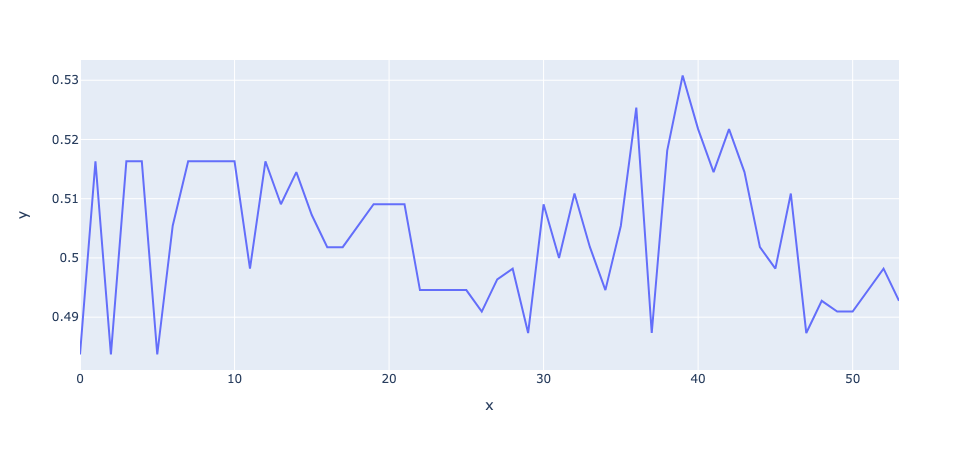

In [59]:
print(backdoorAcc)
fig = px.line(y=backdoorAcc)
fig.show()

[0.49610719084739685, 0.5038928389549255, 0.5038928389549255, 0.5038928389549255, 0.49610719084739685, 0.5038928389549255, 0.49610719084739685, 0.5047981142997742, 0.49610719084739685, 0.5058844685554504, 0.5134890675544739, 0.6983523368835449, 0.6594242453575134, 0.6833242774009705, 0.6874886751174927, 0.7137425541877747, 0.7541191577911377, 0.7705956697463989, 0.7859858870506287, 0.777294933795929, 0.8171283602714539, 0.8296215534210205, 0.8147745728492737, 0.8772406578063965, 0.8821292519569397, 0.8884664177894592, 0.9092884063720703, 0.9107369184494019, 0.9150823950767517, 0.9040376543998718, 0.9132717847824097, 0.9107369184494019, 0.9043998122215271, 0.9018649458885193, 0.9234111905097961, 0.9237732887268066, 0.9143581390380859, 0.9270324110984802, 0.9216005802154541, 0.9286619424819946, 0.9197899699211121, 0.9339127540588379, 0.9321021437644958, 0.9362665414810181, 0.9447764158248901, 0.946768045425415, 0.9453195929527283, 0.9455006122589111, 0.9474923014640808, 0.933007419109344

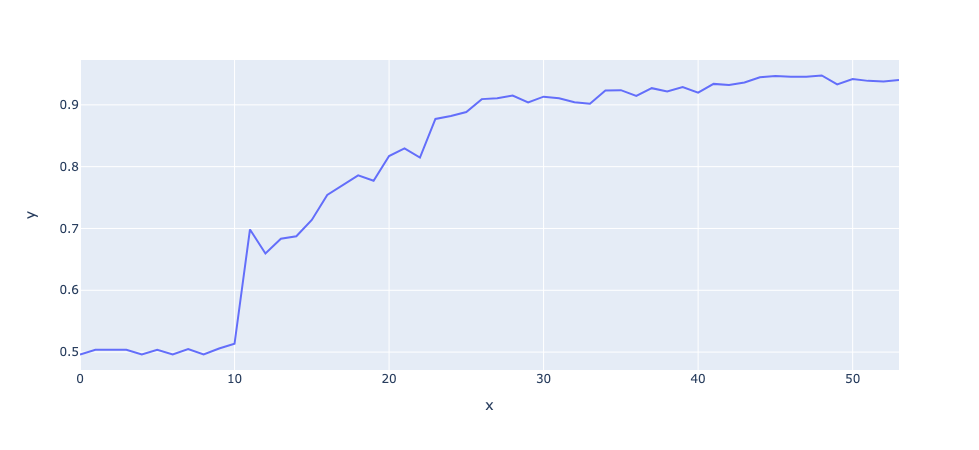

In [66]:
# ## SETTINGS

# # Blockchain
# NUM_Clients = 5 # number of clients contributing per training round

# # ML
# Cluster_Size = 100 # max client dataset size for training
# Batch_Size = 10
# NUM_Epoch = 3
# num_classes = 2

# # Krum
# krum_f = 0.25 # percentage of byzantine nodes

# # Differential Privacy
# Gaussian_Noise = False
# Gaussian_Noise_Std_Dev = 0.10

# Gradient_Clipping = False
# Clip_Norm = 0.25

# Gradient_Pruning = True <-----
# initial_sparsity = 0.00
# final_sparsity = 0.50

# backdoor = True <-----
# poisonedLocals = [1, 11, 22, 99]
print(acc_array)
fig = px.line(y=acc_array)
fig.show()

In [67]:
print(backdoorAcc)
fig = px.line(y=backdoorAcc)
fig.show()

[0.4836956560611725, 0.5163043737411499, 0.5163043737411499, 0.5163043737411499, 0.4836956560611725, 0.5163043737411499, 0.4836956560611725, 0.5163043737411499, 0.4836956560611725, 0.48188406229019165, 0.5144927501678467, 0.5054348111152649, 0.4909420311450958, 0.5072463750839233, 0.5, 0.5, 0.49637681245803833, 0.5054348111152649, 0.5090579986572266, 0.49818840622901917, 0.5036231875419617, 0.510869562625885, 0.5126811861991882, 0.5144927501678467, 0.5271739363670349, 0.5289855003356934, 0.52173912525177, 0.5199275612831116, 0.5235507488250732, 0.5271739363670349, 0.5253623127937317, 0.5471014380455017, 0.5742753744125366, 0.5380434989929199, 0.5833333134651184, 0.5416666865348816, 0.5561594367027283, 0.570652186870575, 0.5344203114509583, 0.5471014380455017, 0.54347825050354, 0.5670289993286133, 0.5289855003356934, 0.5416666865348816, 0.570652186870575, 0.554347813129425, 0.5615941882133484, 0.5634058117866516, 0.5615941882133484, 0.54347825050354, 0.5525362491607666, 0.57789856195449

[0.49610719084739685, 0.49610719084739685, 0.49610719084739685, 0.6275575160980225, 0.49610719084739685, 0.49610719084739685, 0.6194097399711609, 0.6259279251098633, 0.705051600933075, 0.688575029373169, 0.703784167766571, 0.74053955078125, 0.6987144947052002, 0.7081296443939209, 0.7608184218406677, 0.7242440581321716, 0.7490494251251221, 0.7762085795402527, 0.7943146824836731, 0.82256019115448, 0.800470769405365, 0.8298026323318481, 0.8690928816795349, 0.8808618783950806, 0.887380063533783, 0.8933550715446472, 0.9005975127220154, 0.8964331150054932, 0.9062104225158691, 0.9127286076545715, 0.9004164338111877, 0.9132717847824097, 0.9244975447654724, 0.9226869344711304, 0.9315589070320129, 0.9286619424819946, 0.9342748522758484, 0.933369517326355, 0.933369517326355, 0.9317399859428406, 0.9436900019645691, 0.9406119585037231, 0.9422415494918823, 0.9364475607872009, 0.9433279037475586, 0.9398877620697021, 0.9462248682975769, 0.9416983723640442, 0.9422415494918823, 0.9442331790924072, 0.944

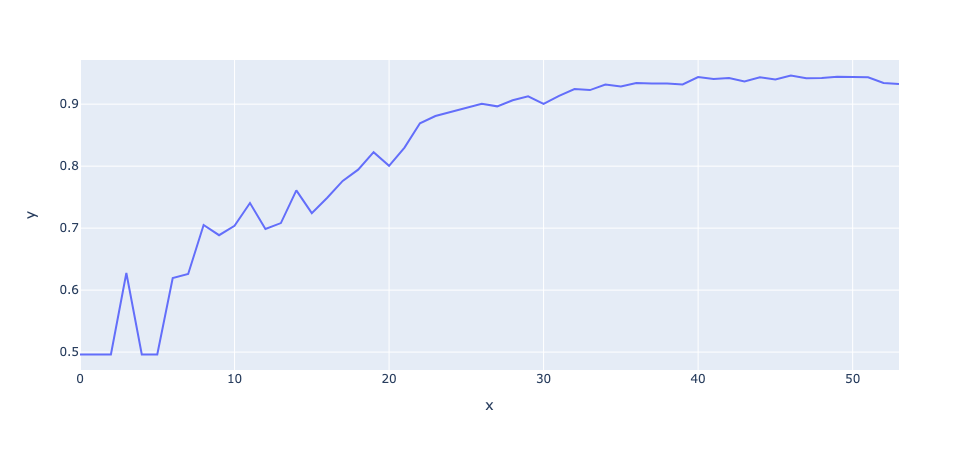

In [74]:
# ## SETTINGS

# # Blockchain
# NUM_Clients = 5 # number of clients contributing per training round

# # ML
# Cluster_Size = 100 # max client dataset size for training
# Batch_Size = 10
# NUM_Epoch = 3
# num_classes = 2

# # Krum
# krum_f = 0.25 # percentage of byzantine nodes

# # Differential Privacy
# Gaussian_Noise = False
# Gaussian_Noise_Std_Dev = 0.10

# Gradient_Clipping = False
# Clip_Norm = 0.25

# Gradient_Pruning = True <-----
# initial_sparsity = 0.00
# final_sparsity = 0.50

# backdoor = True <-----
# poisonedLocals = [1, 11, 22, 99]
print(acc_array)
fig = px.line(y=acc_array)
fig.show()

[0.4836956560611725, 0.4836956560611725, 0.4836956560611725, 0.510869562625885, 0.4836956560611725, 0.4836956560611725, 0.5018116235733032, 0.5054348111152649, 0.5018116235733032, 0.4945652186870575, 0.4945652186870575, 0.49818840622901917, 0.4855072498321533, 0.49637681245803833, 0.5072463750839233, 0.49275362491607666, 0.5018116235733032, 0.49275362491607666, 0.5126811861991882, 0.510869562625885, 0.510869562625885, 0.5054348111152649, 0.5126811861991882, 0.5036231875419617, 0.5253623127937317, 0.52173912525177, 0.510869562625885, 0.5253623127937317, 0.52173912525177, 0.5289855003356934, 0.52173912525177, 0.5163043737411499, 0.5144927501678467, 0.5253623127937317, 0.5271739363670349, 0.5362318754196167, 0.592391312122345, 0.5851449370384216, 0.5869565010070801, 0.5452898740768433, 0.5471014380455017, 0.5525362491607666, 0.5163043737411499, 0.5181159377098083, 0.5615941882133484, 0.5869565010070801, 0.5398550629615784, 0.5416666865348816, 0.5833333134651184, 0.570652186870575, 0.56159

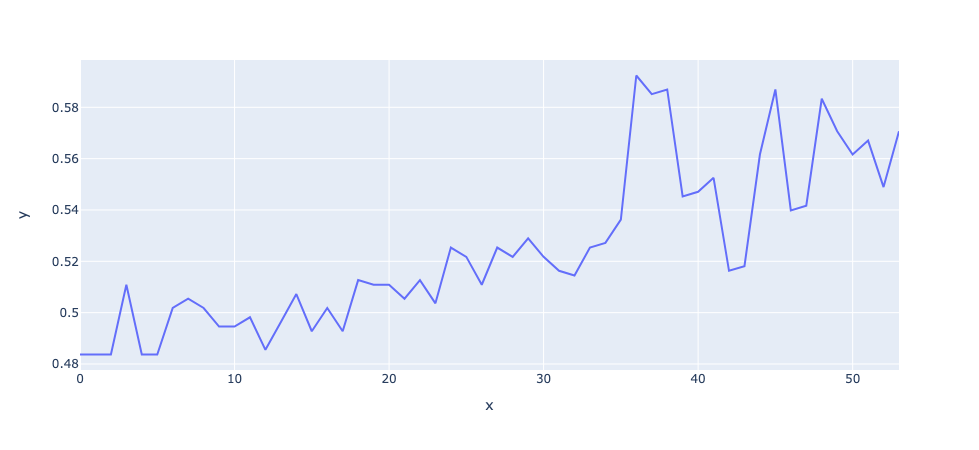

In [75]:
print(backdoorAcc)
fig = px.line(y=backdoorAcc)
fig.show()

[0.5087814331054688, 0.5038928389549255, 0.5038928389549255, 0.5038928389549255, 0.5038928389549255, 0.5038928389549255, 0.5038928389549255, 0.5038928389549255, 0.5038928389549255, 0.5038928389549255, 0.5038928389549255, 0.5053412914276123, 0.5049791932106018, 0.5093246698379517, 0.6206771731376648, 0.5080572366714478, 0.5142132639884949, 0.523809552192688, 0.5058844685554504, 0.5185587406158447, 0.5040738582611084, 0.5889914631843567, 0.5049791932106018, 0.5111352801322937, 0.5057034492492676, 0.5109542012214661, 0.5145754218101501, 0.5267065167427063, 0.5067898035049438, 0.5156617760658264, 0.5120405554771423, 0.509143590927124, 0.5134890675544739, 0.5142132639884949, 0.5172913074493408, 0.5247148275375366, 0.5247148275375366, 0.541010320186615, 0.5236284732818604, 0.5325004458427429, 0.5248959064483643, 0.5364838242530823, 0.5415534973144531, 0.5290603041648865, 0.5232663154602051, 0.5451747179031372, 0.5299655795097351, 0.5408292412757874, 0.5420966744422913, 0.5487959384918213, 0.

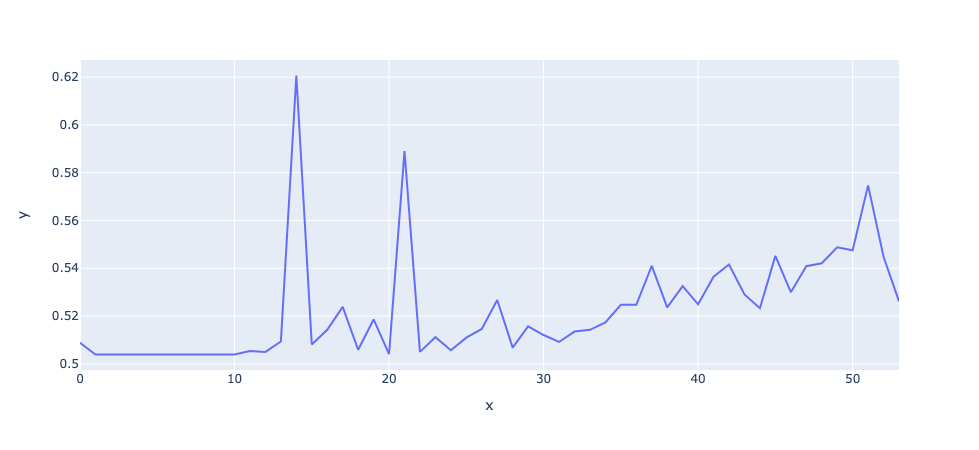

In [97]:
# ## SETTINGS

# # Blockchain
# NUM_Clients = 5 # number of clients contributing per training round

# # ML
# Cluster_Size = 100 # max client dataset size for training
# Batch_Size = 10
# NUM_Epoch = 3
# num_classes = 2

# # Krum
# krum_f = 0.25 # percentage of byzantine nodes

# # Differential Privacy
# Gaussian_Noise = True <----
# Gaussian_Noise_Std_Dev = 0.20

# Gradient_Clipping = False
# Clip_Norm = 0.25

# Gradient_Pruning = False
# initial_sparsity = 0.00
# final_sparsity = 0.50

# backdoor = False
# poisonedLocals = [1, 11, 22, 99]
print(acc_array)
fig = px.line(y=acc_array)
fig.show()

[0.49610719084739685, 0.5049791932106018, 0.5038928389549255, 0.5198261737823486, 0.5793952345848083, 0.5160238742828369, 0.5618323087692261, 0.7039652466773987, 0.7329350113868713, 0.7276841998100281, 0.7189933061599731, 0.7642585635185242, 0.7970306277275085, 0.8091616630554199, 0.8316132426261902, 0.8475466370582581, 0.8515299558639526, 0.8703603148460388, 0.8812239766120911, 0.8913633823394775, 0.9232301115989685, 0.9246786236763, 0.9263081550598145, 0.9355422854423523, 0.9357233643531799, 0.9366286396980286, 0.937533974647522, 0.9478543996810913, 0.941155195236206, 0.9458627700805664, 0.9491218328475952, 0.9482165575027466, 0.9451385140419006, 0.9415172934532166, 0.9455006122589111, 0.9328263401985168, 0.9391635060310364, 0.9397066831588745, 0.9485786557197571, 0.949846088886261, 0.9476733803749084, 0.9438710808753967, 0.9487597346305847, 0.9529241323471069, 0.9494839906692505, 0.9502082467079163, 0.9422415494918823, 0.9509324431419373, 0.9471302032470703, 0.9505703449249268, 0.94

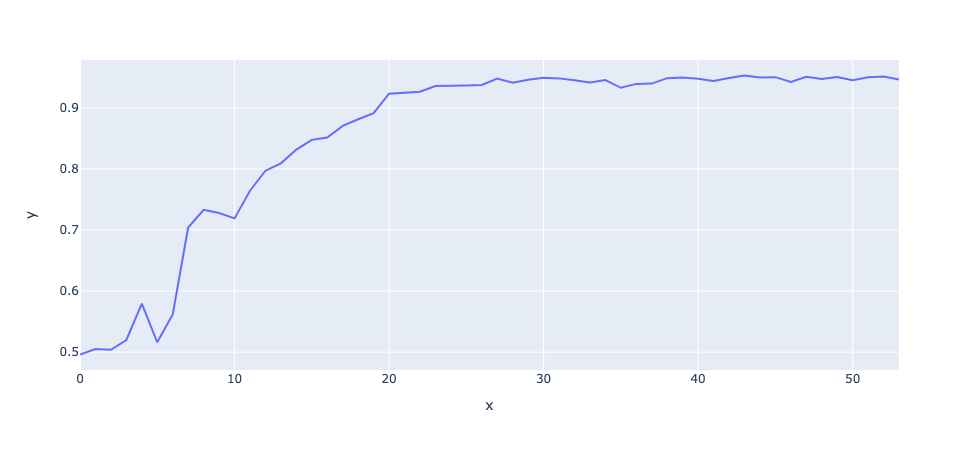

In [105]:
# ## SETTINGS

# # Blockchain
# NUM_Clients = 5 # number of clients contributing per training round

# # ML
# Cluster_Size = 100 # max client dataset size for training
# Batch_Size = 10
# NUM_Epoch = 3
# num_classes = 2

# # Krum
# krum_f = 0.25 # percentage of byzantine nodes

# # Differential Privacy
# Gaussian_Noise = False 
# Gaussian_Noise_Std_Dev = 0.20

# Gradient_Clipping = True <----
# Clip_Norm = 0.75

# Gradient_Pruning = False
# initial_sparsity = 0.00
# final_sparsity = 0.50

# backdoor = False
# poisonedLocals = [1, 11, 22, 99]
print(acc_array)
fig = px.line(y=acc_array)
fig.show()

[0.49610719084739685, 0.49610719084739685, 0.5038928389549255, 0.5038928389549255, 0.5038928389549255, 0.5038928389549255, 0.5038928389549255, 0.5038928389549255, 0.49701249599456787, 0.49610719084739685, 0.5038928389549255, 0.5049791932106018, 0.5049791932106018, 0.5047981142997742, 0.6320840120315552, 0.5040738582611084, 0.5062466263771057, 0.5603838562965393, 0.5306898355484009, 0.5089625120162964, 0.5062466263771057, 0.5315951704978943, 0.5064276456832886, 0.5218178629875183, 0.5174723863601685, 0.5382944345474243, 0.520731508731842, 0.5136700868606567, 0.5422777533531189, 0.5344921350479126, 0.5377511978149414, 0.5359405875205994, 0.5734202265739441, 0.571609616279602, 0.557486891746521, 0.5736013054847717, 0.5819301009178162, 0.6063733696937561, 0.5812058448791504, 0.5942422747612, 0.6842296123504639, 0.6250226497650146, 0.6317219138145447, 0.6541734337806702, 0.6702879071235657, 0.6844106316566467, 0.7016114592552185, 0.6958174705505371, 0.6998008489608765, 0.7177258729934692, 0

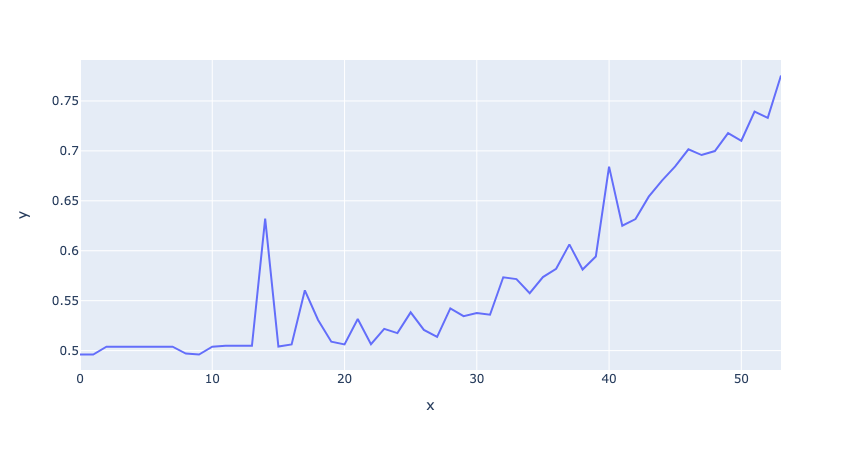

In [114]:
# ## SETTINGS

# # Blockchain
# NUM_Clients = 5 # number of clients contributing per training round

# # ML
# Cluster_Size = 100 # max client dataset size for training
# Batch_Size = 10
# NUM_Epoch = 3
# num_classes = 2

# # Krum
# krum_f = 0.25 # percentage of byzantine nodes

# # Differential Privacy
# Gaussian_Noise = True <----
# Gaussian_Noise_Std_Dev = 0.10

# Gradient_Clipping = False
# Clip_Norm = 0.25

# Gradient_Pruning = False
# initial_sparsity = 0.00
# final_sparsity = 0.50

# backdoor = False
# poisonedLocals = [1, 11, 22, 99]
print(acc_array)
fig = px.line(y=acc_array)
fig.show()

[0.49610719084739685, 0.49610719084739685, 0.49610719084739685, 0.5038928389549255, 0.5038928389549255, 0.49610719084739685, 0.49610719084739685, 0.49610719084739685, 0.49610719084739685, 0.49610719084739685, 0.5038928389549255, 0.504254937171936, 0.5046170353889465, 0.5047981142997742, 0.504254937171936, 0.5057034492492676, 0.5100488662719727, 0.5174723863601685, 0.5093246698379517, 0.6085460782051086, 0.5049791932106018, 0.60094153881073, 0.49610719084739685, 0.49610719084739685, 0.49646931886672974, 0.6418613195419312, 0.6219446063041687, 0.5212746858596802, 0.5187398195266724, 0.5551331043243408, 0.5301466584205627, 0.5321383476257324, 0.5366648435592651, 0.5363027453422546, 0.5290603041648865, 0.5562194585800171, 0.5678073763847351, 0.5770414471626282, 0.5658156871795654, 0.5516929030418396, 0.5770414471626282, 0.5726959705352783, 0.6241173148155212, 0.5935180187225342, 0.6098135113716125, 0.6284627914428711, 0.6559840440750122, 0.6574325561523438, 0.6474741697311401, 0.6697447299

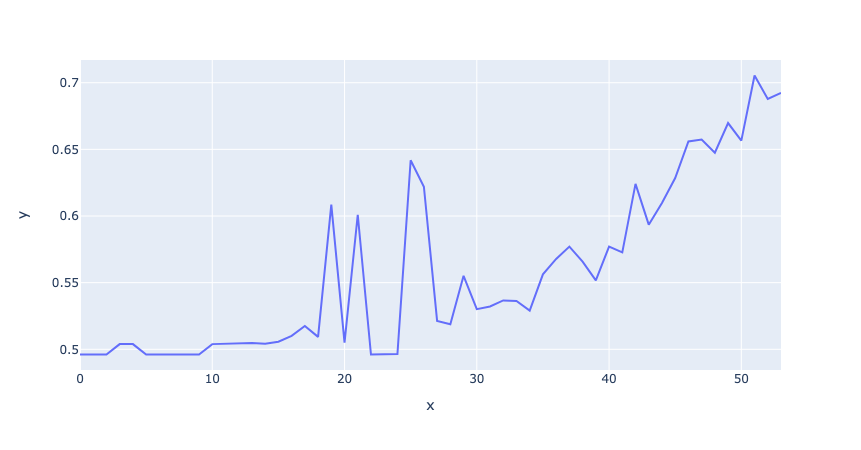

In [122]:
# ## SETTINGS

# # Blockchain
# NUM_Clients = 5 # number of clients contributing per training round

# # ML
# Cluster_Size = 100 # max client dataset size for training
# Batch_Size = 10
# NUM_Epoch = 3
# num_classes = 2

# # Krum
# krum_f = 0.25 # percentage of byzantine nodes

# # Differential Privacy
# Gaussian_Noise = True <----
# Gaussian_Noise_Std_Dev = 0.05

# Gradient_Clipping = False
# Clip_Norm = 0.25

# Gradient_Pruning = False
# initial_sparsity = 0.00
# final_sparsity = 0.50

# backdoor = False
# poisonedLocals = [1, 11, 22, 99]
print(acc_array)
fig = px.line(y=acc_array)
fig.show()

[0.49610719084739685, 0.5803005695343018, 0.5038928389549255, 0.504254937171936, 0.5227231383323669, 0.6060112118721008, 0.6309976577758789, 0.6246604919433594, 0.619952917098999, 0.6436719298362732, 0.6581568121910095, 0.65181964635849, 0.6909288167953491, 0.7023357152938843, 0.6981712579727173, 0.7175447940826416, 0.720260739326477, 0.7564729452133179, 0.7581024765968323, 0.7651638388633728, 0.7620857954025269, 0.7946767807006836, 0.8223791122436523, 0.8328806757926941, 0.8325185775756836, 0.8417526483535767, 0.8645663857460022, 0.8721709251403809, 0.8739815354347229, 0.8890095949172974, 0.9078399538993835, 0.9183414578437805, 0.9145392179489136, 0.9254028797149658, 0.9268513321876526, 0.9321021437644958, 0.933369517326355, 0.9288430213928223, 0.9384392499923706, 0.9438710808753967, 0.9384392499923706, 0.9349991083145142, 0.938258171081543, 0.9398877620697021, 0.9440521597862244, 0.933369517326355, 0.9424225687980652, 0.9438710808753967, 0.9447764158248901, 0.9438710808753967, 0.9384

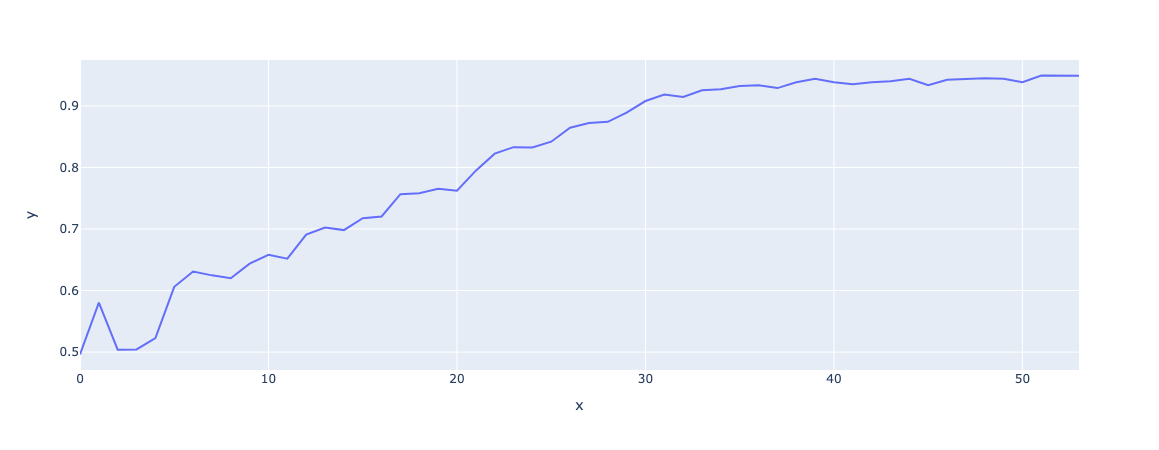

In [173]:
# ## SETTINGS

# # Blockchain
# NUM_Clients = 5 # number of clients contributing per training round

# # ML
# Cluster_Size = 100 # max client dataset size for training
# Batch_Size = 10
# NUM_Epoch = 3
# num_classes = 2

# # Krum
# krum_f = 0.25 # percentage of byzantine nodes

# # Differential Privacy
# Gaussian_Noise = False
# Gaussian_Noise_Std_Dev = 0.05

# Gradient_Clipping = True <----
# Clip_Norm = 0.90

# Gradient_Pruning = False
# initial_sparsity = 0.00
# final_sparsity = 0.50

# backdoor = False
# poisonedLocals = [1, 11, 22, 99]
print(acc_array)
fig = px.line(y=acc_array)
fig.show()

[0.49610719084739685, 0.5038928389549255, 0.5038928389549255, 0.5038928389549255, 0.5038928389549255, 0.5051602125167847, 0.49610719084739685, 0.673184871673584, 0.6078218221664429, 0.6815136671066284, 0.6029331684112549, 0.7007061243057251, 0.7267789244651794, 0.7327539324760437, 0.7343834638595581, 0.7702335715293884, 0.773492693901062, 0.8384935855865479, 0.8334238529205322, 0.8406662940979004, 0.8375882506370544, 0.8576860427856445, 0.8788701891899109, 0.8788701891899109, 0.8862937092781067, 0.8969762921333313, 0.8973383903503418, 0.9096505641937256, 0.922868013381958, 0.9252218008041382, 0.9306536316871643, 0.9286619424819946, 0.933369517326355, 0.9281187653541565, 0.9250407218933105, 0.933369517326355, 0.9257649779319763, 0.9389824271202087, 0.9389824271202087, 0.938258171081543, 0.9406119585037231, 0.941879391670227, 0.9398877620697021, 0.941879391670227, 0.9339127540588379, 0.9427847266197205, 0.9447764158248901, 0.9433279037475586, 0.9483976364135742, 0.9464059472084045, 0.937

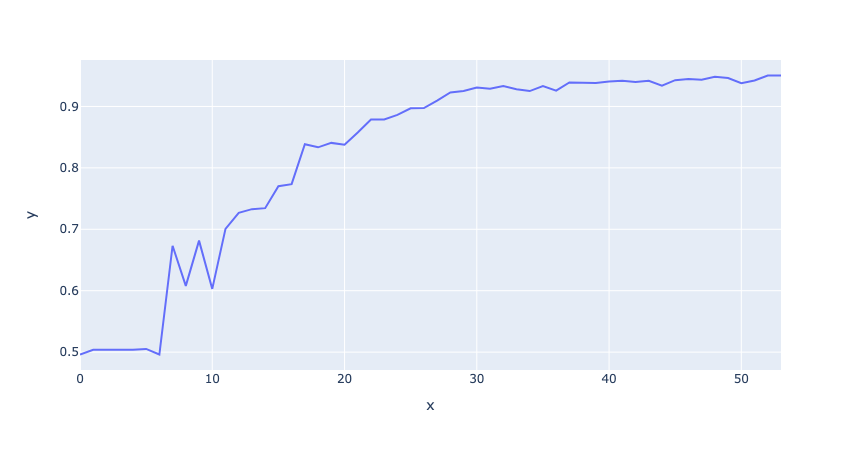

In [179]:
# ## SETTINGS

# # Blockchain
# NUM_Clients = 5 # number of clients contributing per training round

# # ML
# Cluster_Size = 100 # max client dataset size for training
# Batch_Size = 10
# NUM_Epoch = 3
# num_classes = 2

# # Krum
# krum_f = 0.25 # percentage of byzantine nodes

# # Differential Privacy
# Gaussian_Noise = False
# Gaussian_Noise_Std_Dev = 0.05

# Gradient_Clipping = True <----
# Clip_Norm = 0.60

# Gradient_Pruning = False
# initial_sparsity = 0.00
# final_sparsity = 0.50

# backdoor = False
# poisonedLocals = [1, 11, 22, 99]
print(acc_array)
fig = px.line(y=acc_array)
fig.show()

[0.49610719084739685, 0.5038928389549255, 0.5038928389549255, 0.5038928389549255, 0.5095056891441345, 0.49610719084739685, 0.4979178011417389, 0.6190476417541504, 0.6610537767410278, 0.6900235414505005, 0.6485605835914612, 0.7416259050369263, 0.7168205976486206, 0.7383668422698975, 0.7537569999694824, 0.7571972012519836, 0.773492693901062, 0.7684229612350464, 0.7946767807006836, 0.7852616310119629, 0.797392725944519, 0.8122397065162659, 0.8261814117431641, 0.8542459011077881, 0.8604019284248352, 0.8781459331512451, 0.8897338509559631, 0.9025892019271851, 0.9083831310272217, 0.9114611744880676, 0.9201520681381226, 0.9187036156654358, 0.9203331470489502, 0.9216005802154541, 0.9246786236763, 0.9208763241767883, 0.9226869344711304, 0.9371718168258667, 0.9308347105979919, 0.9293861985206604, 0.9335505962371826, 0.9388013482093811, 0.9369907379150391, 0.9406119585037231, 0.934455931186676, 0.9360854625701904, 0.939344584941864, 0.9386203289031982, 0.9402498602867126, 0.946768045425415, 0.940

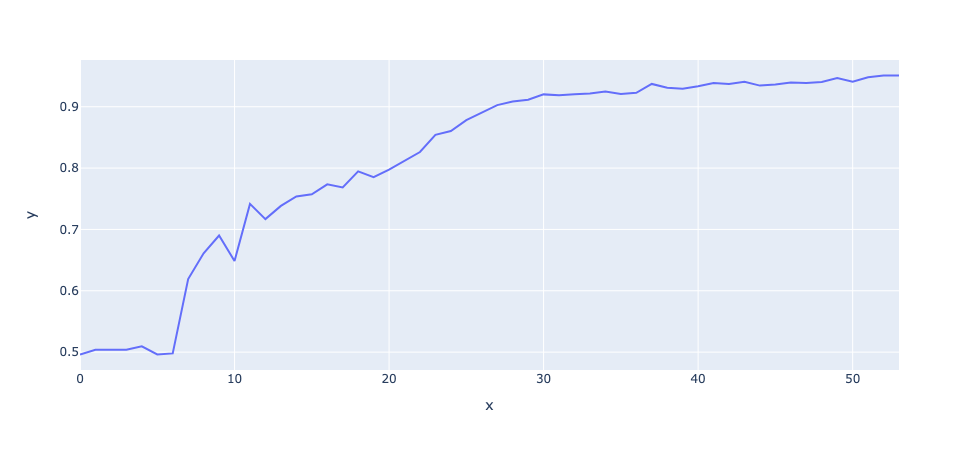

In [190]:
# ## SETTINGS

# # Blockchain
# NUM_Clients = 5 # number of clients contributing per training round

# # ML
# Cluster_Size = 100 # max client dataset size for training
# Batch_Size = 10
# NUM_Epoch = 3
# num_classes = 2

# # Krum
# krum_f = 0.25 # percentage of byzantine nodes

# # Differential Privacy 
# Gaussian_Noise = False
# Gaussian_Noise_Std_Dev = 0.05

# Gradient_Clipping = False 
# Clip_Norm = 0.60

# Gradient_Pruning = True <----
# initial_sparsity = 0.00
# final_sparsity = 0.25

# backdoor = False
# poisonedLocals = [1, 11, 22, 99]
print(acc_array)
fig = px.line(y=acc_array)
fig.show()

[0.49610719084739685, 0.5808437466621399, 0.5851892232894897, 0.5038928389549255, 0.5038928389549255, 0.5038928389549255, 0.49610719084739685, 0.6378779411315918, 0.6489226818084717, 0.65181964635849, 0.5339489579200745, 0.6376969218254089, 0.6309976577758789, 0.6789788007736206, 0.6771681904792786, 0.653630256652832, 0.7026978135108948, 0.7030599117279053, 0.7083107233047485, 0.7032409906387329, 0.7284084558486938, 0.7399963736534119, 0.742350161075592, 0.7468767166137695, 0.7419880628585815, 0.780916154384613, 0.8042730689048767, 0.7705956697463989, 0.7944957613945007, 0.8499004244804382, 0.8703603148460388, 0.8850262761116028, 0.8955277800559998, 0.8870179057121277, 0.9027702212333679, 0.898967981338501, 0.9005975127220154, 0.9062104225158691, 0.9143581390380859, 0.9192467927932739, 0.9181604385375977, 0.9217816591262817, 0.9322831630706787, 0.9337316751480103, 0.9281187653541565, 0.9282998442649841, 0.9360854625701904, 0.9377149939537048, 0.9389824271202087, 0.938258171081543, 0.94

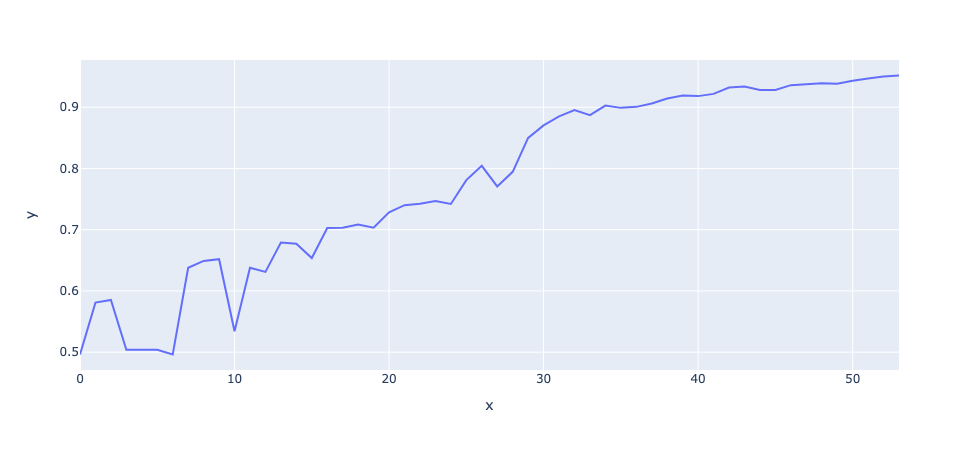

In [200]:
# ## SETTINGS

# # Blockchain
# NUM_Clients = 5 # number of clients contributing per training round

# # ML
# Cluster_Size = 100 # max client dataset size for training
# Batch_Size = 10
# NUM_Epoch = 3
# num_classes = 2

# # Krum
# krum_f = 0.25 # percentage of byzantine nodes

# # Differential Privacy 
# Gaussian_Noise = False
# Gaussian_Noise_Std_Dev = 0.05

# Gradient_Clipping = False 
# Clip_Norm = 0.60

# Gradient_Pruning = True <----
# initial_sparsity = 0.00
# final_sparsity = 0.75

# backdoor = False
# poisonedLocals = [1, 11, 22, 99]
print(acc_array)
fig = px.line(y=acc_array)
fig.show()

[0.49610719084739685, 0.49610719084739685, 0.49610719084739685, 0.49610719084739685, 0.5040738582611084, 0.5223610401153564, 0.6840485334396362, 0.521455705165863, 0.7008872032165527, 0.713561475276947, 0.7032409906387329, 0.7081296443939209, 0.7242440581321716, 0.6849538087844849, 0.7428933382034302, 0.6996197700500488, 0.7437986731529236, 0.7191743850708008, 0.7754843235015869, 0.7863479852676392, 0.7729494571685791, 0.7562918663024902, 0.8011950254440308, 0.8223791122436523, 0.8303458094596863, 0.8441064357757568, 0.895889937877655, 0.8788701891899109, 0.9043998122215271, 0.9143581390380859, 0.8730762004852295, 0.9016838669776917, 0.9078399538993835, 0.9174361824989319, 0.8734383583068848, 0.8857504725456238, 0.9043998122215271, 0.8955277800559998, 0.9293861985206604, 0.9185225367546082, 0.9183414578437805, 0.9239543676376343, 0.9016838669776917, 0.9065725207328796, 0.9212384819984436, 0.9212384819984436, 0.9127286076545715, 0.934455931186676, 0.9331884980201721, 0.9234111905097961,

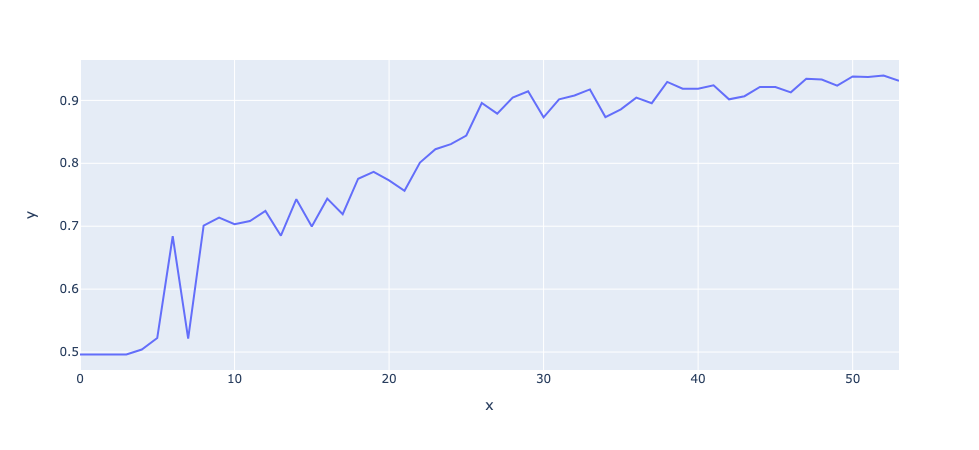

In [229]:
## SETTINGS

# # Blockchain
# NUM_Clients = 5 # number of clients contributing per training round

# # ML
# Cluster_Size = 100 # max client dataset size for training
# Batch_Size = 10
# NUM_Epoch = 3
# num_classes = 2

# # Krum
# krum_f = 0.25 # percentage of byzantine nodes

# # Differential Privacy
# Gaussian_Noise = False
# Gaussian_Noise_Std_Dev = 0.05

# Gradient_Clipping = False
# Clip_Norm = 0.60

# Gradient_Pruning = False
# initial_sparsity = 0.00
# final_sparsity = 0.75

# backdoor = True
# poisonedLocals = [1, 2, 3]
print(acc_array)
fig = px.line(y=acc_array)
fig.show()

[0.5072463750839233, 0.5072463750839233, 0.5072463750839233, 0.5072463750839233, 0.49275362491607666, 0.489130437374115, 0.4836956560611725, 0.4909420311450958, 0.4583333432674408, 0.4547101557254791, 0.46195653080940247, 0.46014493703842163, 0.4474637806415558, 0.47101449966430664, 0.4528985619544983, 0.47101449966430664, 0.4637681245803833, 0.4728260934352875, 0.4728260934352875, 0.48731884360313416, 0.4800724685192108, 0.4909420311450958, 0.4945652186870575, 0.47101449966430664, 0.4800724685192108, 0.5018116235733032, 0.4836956560611725, 0.4855072498321533, 0.489130437374115, 0.4909420311450958, 0.5018116235733032, 0.5072463750839233, 0.5, 0.5090579986572266, 0.5163043737411499, 0.5163043737411499, 0.4945652186870575, 0.5018116235733032, 0.510869562625885, 0.5018116235733032, 0.510869562625885, 0.48731884360313416, 0.5181159377098083, 0.5036231875419617, 0.5054348111152649, 0.5126811861991882, 0.49637681245803833, 0.5054348111152649, 0.49818840622901917, 0.5018116235733032, 0.509057

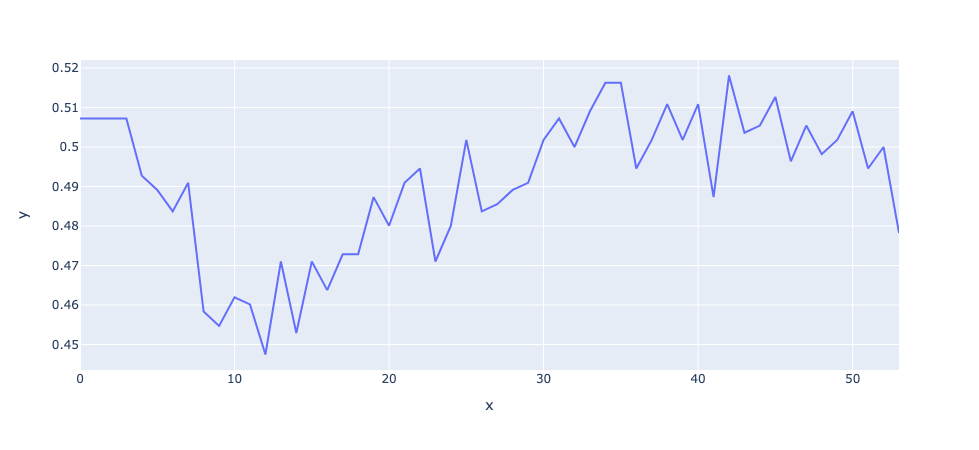

In [230]:
print(backdoorAcc)
fig = px.line(y=backdoorAcc, ya)
fig.show()

[0.49646931886672974, 0.49610719084739685, 0.5936990976333618, 0.4968314468860626, 0.5149375200271606, 0.504254937171936, 0.6217635273933411, 0.6516386270523071, 0.6471120715141296, 0.7066811323165894, 0.7296758890151978, 0.7327539324760437, 0.7662502527236938, 0.720260739326477, 0.7743979692459106, 0.7611805200576782, 0.8135071396827698, 0.8211117386817932, 0.8636610507965088, 0.8799565434455872, 0.8607640862464905, 0.8871989846229553, 0.8888285160064697, 0.91797935962677, 0.9185225367546082, 0.9091073870658875, 0.9020459651947021, 0.9181604385375977, 0.9273945093154907, 0.9286619424819946, 0.9234111905097961, 0.9257649779319763, 0.9223248362541199, 0.9241354465484619, 0.9324642419815063, 0.9384392499923706, 0.9315589070320129, 0.935180127620697, 0.9366286396980286, 0.9415172934532166, 0.9469491243362427, 0.9478543996810913, 0.9460437893867493, 0.9360854625701904, 0.9395256042480469, 0.9455006122589111, 0.9464059472084045, 0.9433279037475586, 0.9514756202697754, 0.946768045425415, 0.9

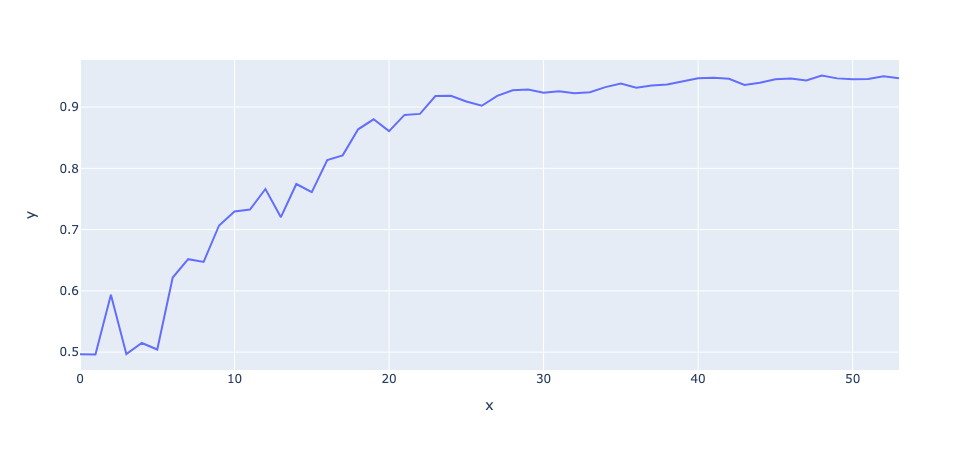

In [244]:
## SETTINGS

# # Blockchain
# NUM_Clients = 5 # number of clients contributing per training round

# # ML
# Cluster_Size = 100 # max client dataset size for training
# Batch_Size = 10
# NUM_Epoch = 3
# num_classes = 2

# # Krum
# krum_f = 0.25 # percentage of byzantine nodes

# # Differential Privacy
# Gaussian_Noise = False
# Gaussian_Noise_Std_Dev = 0.05

# Gradient_Clipping = False
# Clip_Norm = 0.60

# Gradient_Pruning = False
# initial_sparsity = 0.00
# final_sparsity = 0.75

# backdoor = True
# poisonedLocals = [1, 2, 3, 4, 5]
print(acc_array)
fig = px.line(y=acc_array)
fig.show()

[0.5072463750839233, 0.5072463750839233, 0.5235507488250732, 0.5072463750839233, 0.4909420311450958, 0.49275362491607666, 0.49637681245803833, 0.4692029058933258, 0.4692029058933258, 0.45108696818351746, 0.45108696818351746, 0.4384058117866516, 0.4492753744125366, 0.4692029058933258, 0.4637681245803833, 0.4637681245803833, 0.4583333432674408, 0.45108696818351746, 0.4528985619544983, 0.4474637806415558, 0.45652174949645996, 0.4528985619544983, 0.46014493703842163, 0.45652174949645996, 0.46557971835136414, 0.4492753744125366, 0.4547101557254791, 0.4528985619544983, 0.46557971835136414, 0.5072463750839233, 0.48188406229019165, 0.45652174949645996, 0.4583333432674408, 0.47826087474823, 0.4728260934352875, 0.47644928097724915, 0.4547101557254791, 0.4909420311450958, 0.52173912525177, 0.4746376872062683, 0.5144927501678467, 0.5126811861991882, 0.5344203114509583, 0.46739131212234497, 0.5054348111152649, 0.5036231875419617, 0.5289855003356934, 0.5307971239089966, 0.5778985619544983, 0.5344203

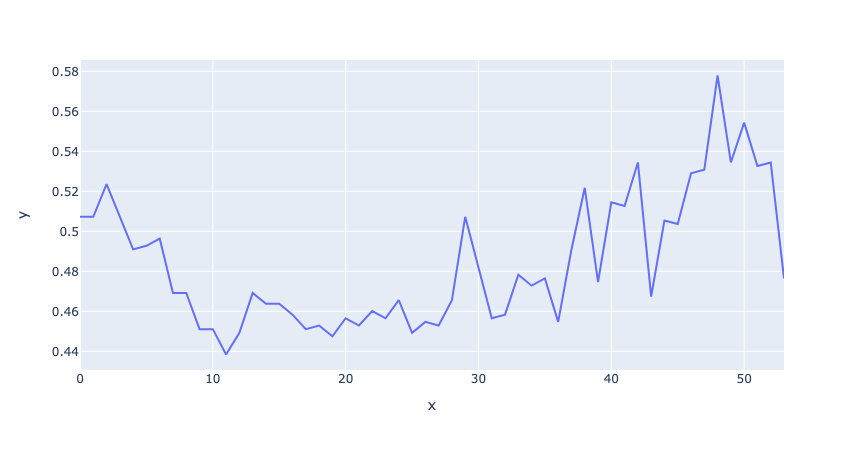

In [246]:
print(backdoorAcc)
fig = px.line(y=backdoorAcc)
fig.show()

[0.5038928389549255, 0.5040738582611084, 0.49610719084739685, 0.5285171270370483, 0.5243527293205261, 0.6244794726371765, 0.6625022888183594, 0.6882129311561584, 0.7010682821273804, 0.7191743850708008, 0.721528172492981, 0.7025167346000671, 0.7700524926185608, 0.7260546684265137, 0.738728940486908, 0.8055404424667358, 0.7917798161506653, 0.840847373008728, 0.8464602828025818, 0.8450117707252502, 0.8902770280838013, 0.9024081230163574, 0.8971573710441589, 0.9105558395385742, 0.9136338829994202, 0.9127286076545715, 0.9183414578437805, 0.9223248362541199, 0.9205142259597778, 0.9288430213928223, 0.9226869344711304, 0.9302915334701538, 0.9293861985206604, 0.9261270761489868, 0.9263081550598145, 0.9261270761489868, 0.9337316751480103, 0.9360854625701904, 0.927756667137146, 0.9453195929527283, 0.9254028797149658, 0.935180127620697, 0.9427847266197205, 0.9464059472084045, 0.9451385140419006, 0.9409741163253784, 0.9438710808753967, 0.9335505962371826, 0.9388013482093811, 0.9491218328475952, 0.9

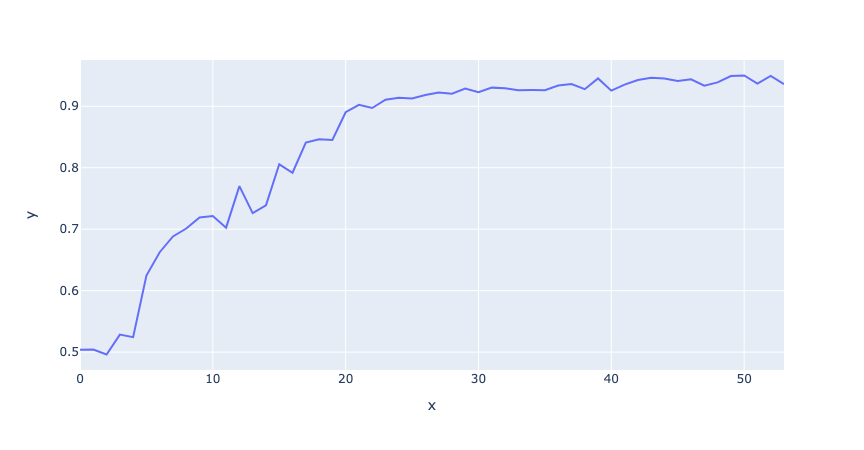

In [273]:
## SETTINGS

# # Blockchain
# NUM_Clients = 5 # number of clients contributing per training round

# # ML
# Cluster_Size = 100 # max client dataset size for training
# Batch_Size = 10
# NUM_Epoch = 3
# num_classes = 2

# # Krum
# krum_f = 0.25 # percentage of byzantine nodes

# # Differential Privacy
# Gaussian_Noise = False
# Gaussian_Noise_Std_Dev = 0.05

# Gradient_Clipping = False
# Clip_Norm = 0.60

# Gradient_Pruning = False
# initial_sparsity = 0.00
# final_sparsity = 0.75

# backdoor = True
# poisonedLocals = [1, 2, 3, 4, 5]
print(acc_array)
fig = px.line(y=acc_array)
fig.show()

[0.510869562625885, 0.5054348111152649, 0.489130437374115, 0.5054348111152649, 0.5072463750839233, 0.489130437374115, 0.489130437374115, 0.4909420311450958, 0.47826087474823, 0.49818840622901917, 0.4746376872062683, 0.47644928097724915, 0.489130437374115, 0.489130437374115, 0.49818840622901917, 0.5036231875419617, 0.49818840622901917, 0.5, 0.5072463750839233, 0.5289855003356934, 0.5054348111152649, 0.5018116235733032, 0.5, 0.5054348111152649, 0.510869562625885, 0.5018116235733032, 0.5036231875419617, 0.510869562625885, 0.5036231875419617, 0.5199275612831116, 0.5235507488250732, 0.510869562625885, 0.5362318754196167, 0.49818840622901917, 0.5126811861991882, 0.5018116235733032, 0.5036231875419617, 0.5163043737411499, 0.5054348111152649, 0.5199275612831116, 0.5271739363670349, 0.5018116235733032, 0.5416666865348816, 0.5670289993286133, 0.5688405632972717, 0.58152174949646, 0.5398550629615784, 0.5797101259231567, 0.5724637508392334, 0.532608687877655, 0.5163043737411499, 0.5018116235733032

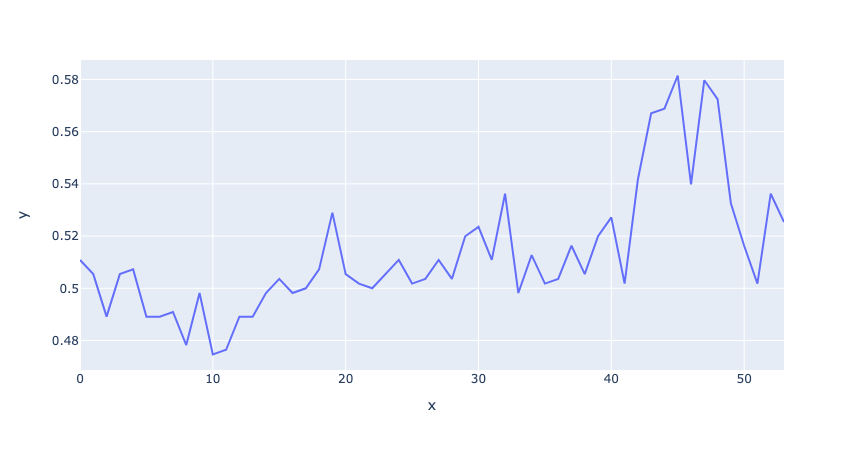

In [272]:
print(backdoorAcc)
fig = px.line(y=backdoorAcc)
fig.show()

[0.5038928389549255, 0.49610719084739685, 0.49610719084739685, 0.49610719084739685, 0.5038928389549255, 0.5850081443786621, 0.5985877513885498, 0.5066087245941162, 0.5057034492492676, 0.5046170353889465, 0.5102299451828003, 0.5303277373313904, 0.5277928709983826, 0.5104110240936279, 0.5098678469657898, 0.5124026536941528, 0.515842854976654, 0.5162049531936646, 0.5057034492492676, 0.5143943428993225, 0.5102299451828003, 0.5475285053253174, 0.5585732460021973, 0.5589353442192078, 0.6136158108711243, 0.5879051089286804, 0.5900778770446777, 0.5573058128356934, 0.5842838883399963, 0.6597863435745239, 0.5755929946899414, 0.6362484097480774, 0.5955097079277039, 0.6612348556518555, 0.6961796283721924, 0.6789788007736206, 0.6644939184188843, 0.6845917105674744, 0.6869454979896545, 0.7177258729934692, 0.7030599117279053, 0.7010682821273804, 0.7119319438934326, 0.7256925702095032, 0.7213470935821533, 0.7336592674255371, 0.7465145587921143, 0.7450661063194275, 0.7293137907981873, 0.781459331512451

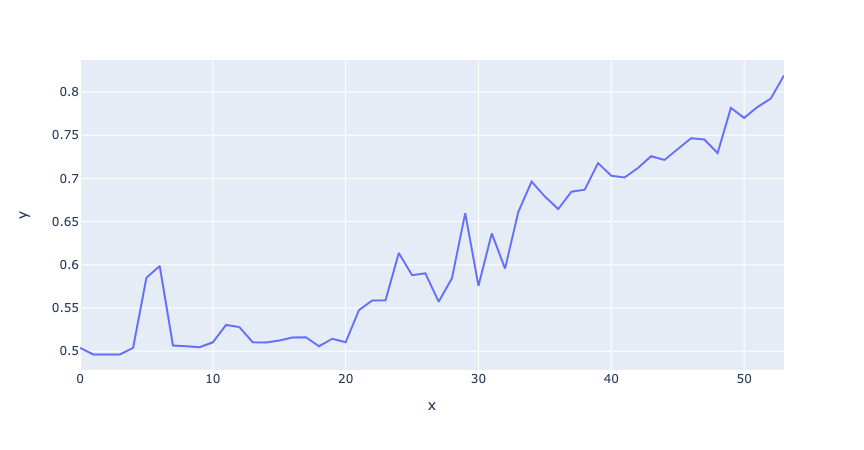

In [284]:
## SETTINGS

# # Blockchain
# NUM_Clients = 5 # number of clients contributing per training round

# # ML
# Cluster_Size = 100 # max client dataset size for training
# Batch_Size = 10
# NUM_Epoch = 3
# num_classes = 2

# # Krum
# krum_f = 0.25 # percentage of byzantine nodes

# # Differential Privacy
# Gaussian_Noise = True
# Gaussian_Noise_Std_Dev = 0.10

# Gradient_Clipping = False
# Clip_Norm = 0.60

# Gradient_Pruning = False
# initial_sparsity = 0.00
# final_sparsity = 0.75

# backdoor = True
# poisonedLocals = [1, 2, 3, 4, 5]
print(acc_array)
fig = px.line(y=acc_array)
fig.show()

[0.510869562625885, 0.489130437374115, 0.489130437374115, 0.489130437374115, 0.510869562625885, 0.49275362491607666, 0.49275362491607666, 0.5054348111152649, 0.5072463750839233, 0.510869562625885, 0.5054348111152649, 0.5036231875419617, 0.5054348111152649, 0.5054348111152649, 0.5054348111152649, 0.5072463750839233, 0.5054348111152649, 0.5036231875419617, 0.5090579986572266, 0.5054348111152649, 0.5072463750839233, 0.5, 0.489130437374115, 0.4945652186870575, 0.48188406229019165, 0.49637681245803833, 0.47644928097724915, 0.49275362491607666, 0.5, 0.46557971835136414, 0.5054348111152649, 0.47644928097724915, 0.4945652186870575, 0.4728260934352875, 0.4746376872062683, 0.4800724685192108, 0.47644928097724915, 0.46739131212234497, 0.4746376872062683, 0.4637681245803833, 0.4836956560611725, 0.4836956560611725, 0.4800724685192108, 0.49637681245803833, 0.46739131212234497, 0.4909420311450958, 0.48731884360313416, 0.47644928097724915, 0.49818840622901917, 0.47644928097724915, 0.5072463750839233, 

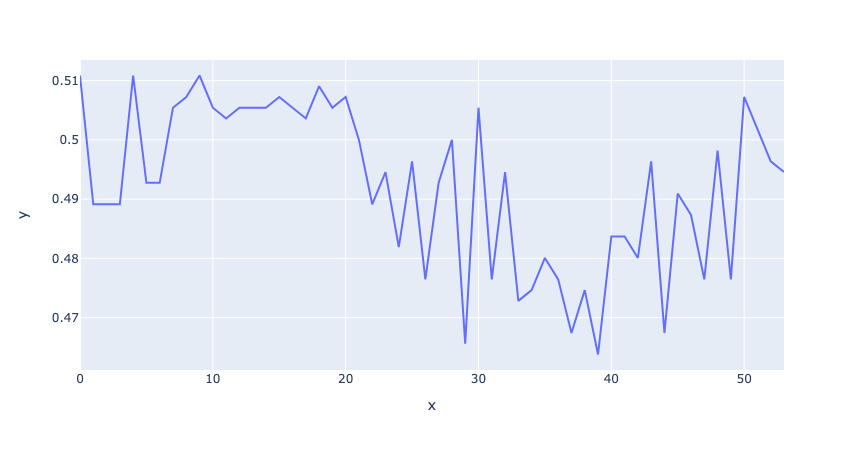

In [285]:
print(backdoorAcc)
fig = px.line(y=backdoorAcc)
fig.show()

[0.5040738582611084, 0.5037117600440979, 0.49610719084739685, 0.504254937171936, 0.6221256852149963, 0.5897157192230225, 0.5917074084281921, 0.5926126837730408, 0.6175991296768188, 0.6179612278938293, 0.6295491456985474, 0.6646749973297119, 0.6577946543693542, 0.6911098957061768, 0.7090349197387695, 0.7253304123878479, 0.7180879712104797, 0.7345645427703857, 0.7280463576316833, 0.7486873269081116, 0.772406280040741, 0.8236465454101562, 0.8377693295478821, 0.8497193455696106, 0.8435632586479187, 0.8689118027687073, 0.8774216771125793, 0.8897338509559631, 0.8848451972007751, 0.900778591632843, 0.9150823950767517, 0.916168749332428, 0.9158066511154175, 0.9134528040885925, 0.9284809231758118, 0.9299293756484985, 0.9230490922927856, 0.9369907379150391, 0.9402498602867126, 0.9442331790924072, 0.944957435131073, 0.9355422854423523, 0.9395256042480469, 0.9438710808753967, 0.9445953369140625, 0.9460437893867493, 0.949846088886261, 0.9489408135414124, 0.9402498602867126, 0.9464059472084045, 0.94

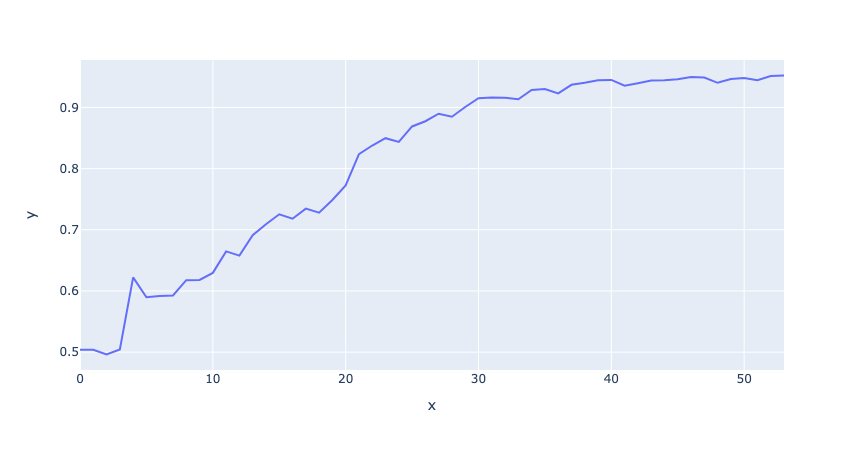

In [291]:
## SETTINGS

# # Blockchain
# NUM_Clients = 5 # number of clients contributing per training round

# # ML
# Cluster_Size = 100 # max client dataset size for training
# Batch_Size = 10
# NUM_Epoch = 3
# num_classes = 2

# # Krum
# krum_f = 0.25 # percentage of byzantine nodes

# # Differential Privacy
# Gaussian_Noise = False
# Gaussian_Noise_Std_Dev = 0.10

# Gradient_Clipping = True
# Clip_Norm = 0.60

# Gradient_Pruning = False
# initial_sparsity = 0.00
# final_sparsity = 0.75

# backdoor = True
# poisonedLocals = [1, 2, 3, 4, 5]
print(acc_array)
fig = px.line(y=acc_array)
fig.show()

[0.510869562625885, 0.510869562625885, 0.489130437374115, 0.510869562625885, 0.49818840622901917, 0.48731884360313416, 0.4836956560611725, 0.4855072498321533, 0.49275362491607666, 0.4945652186870575, 0.4855072498321533, 0.4945652186870575, 0.4836956560611725, 0.4909420311450958, 0.48188406229019165, 0.489130437374115, 0.4800724685192108, 0.4800724685192108, 0.489130437374115, 0.489130437374115, 0.5, 0.49818840622901917, 0.5054348111152649, 0.5090579986572266, 0.5090579986572266, 0.5054348111152649, 0.5163043737411499, 0.5072463750839233, 0.5018116235733032, 0.5090579986572266, 0.510869562625885, 0.5144927501678467, 0.5018116235733032, 0.5018116235733032, 0.5018116235733032, 0.5090579986572266, 0.5090579986572266, 0.5054348111152649, 0.5036231875419617, 0.5054348111152649, 0.5036231875419617, 0.5090579986572266, 0.5253623127937317, 0.532608687877655, 0.510869562625885, 0.5452898740768433, 0.5126811861991882, 0.5090579986572266, 0.5126811861991882, 0.5054348111152649, 0.5054348111152649,

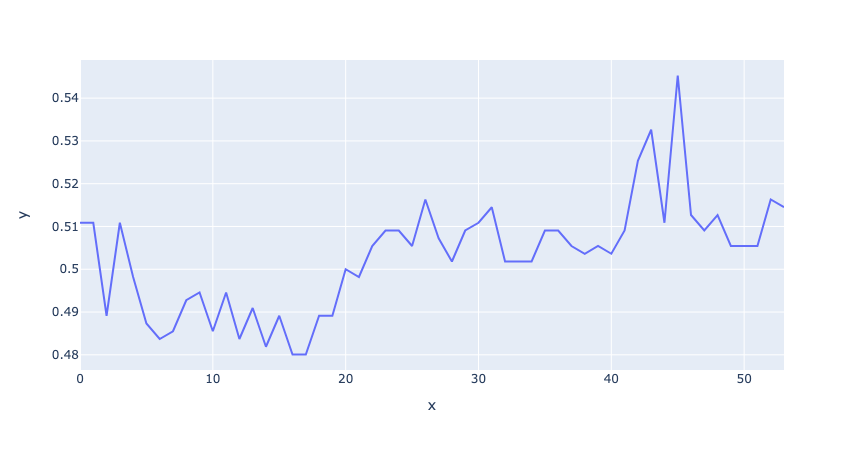

In [292]:
print(backdoorAcc)
fig = px.line(y=backdoorAcc)
fig.show()

[0.5038928389549255, 0.6090892553329468, 0.49610719084739685, 0.5200072526931763, 0.5038928389549255, 0.6005793809890747, 0.5927937626838684, 0.6252036690711975, 0.6516386270523071, 0.6659424304962158, 0.6748144030570984, 0.6876697540283203, 0.7209849953651428, 0.6483795046806335, 0.7121129631996155, 0.7171826958656311, 0.7101213335990906, 0.7434365153312683, 0.738728940486908, 0.7428933382034302, 0.7894260287284851, 0.8073510527610779, 0.8355966210365295, 0.8410284519195557, 0.862936794757843, 0.8777838349342346, 0.8508056998252869, 0.8642042279243469, 0.9005975127220154, 0.9065725207328796, 0.9076588749885559, 0.9098315834999084, 0.9038565754890442, 0.906391441822052, 0.9266703128814697, 0.9254028797149658, 0.9194278717041016, 0.9246786236763, 0.9282998442649841, 0.935180127620697, 0.9273945093154907, 0.9270324110984802, 0.9359043836593628, 0.9442331790924072, 0.9330074191093445, 0.9404309391975403, 0.9359043836593628, 0.9373528957366943, 0.9378960728645325, 0.9478543996810913, 0.938

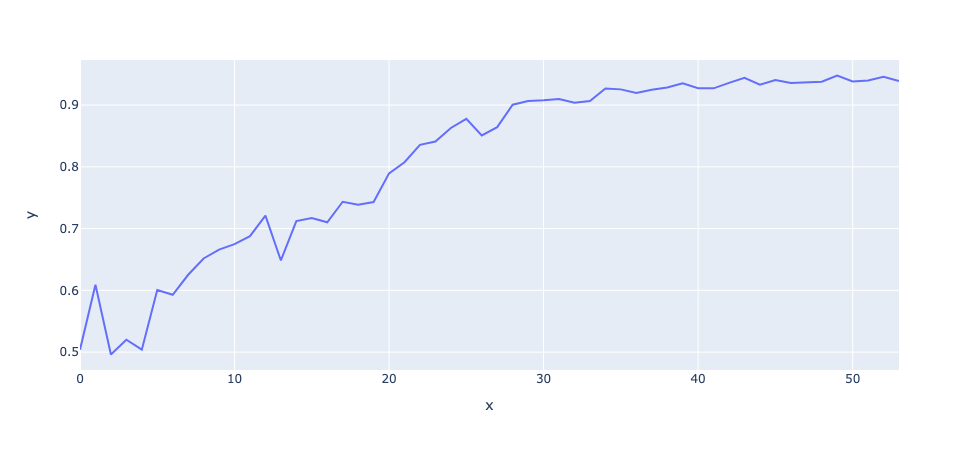

In [298]:
## SETTINGS

# # Blockchain
# NUM_Clients = 5 # number of clients contributing per training round

# # ML
# Cluster_Size = 100 # max client dataset size for training
# Batch_Size = 10
# NUM_Epoch = 3
# num_classes = 2

# # Krum
# krum_f = 0.25 # percentage of byzantine nodes

# # Differential Privacy
# Gaussian_Noise = False
# Gaussian_Noise_Std_Dev = 0.10

# Gradient_Clipping = False
# Clip_Norm = 0.60

# Gradient_Pruning = True
# initial_sparsity = 0.00
# final_sparsity = 0.50

# backdoor = True
# poisonedLocals = [1, 2, 3, 4, 5]
print(acc_array)
fig = px.line(y=acc_array)
fig.show()

[0.510869562625885, 0.5072463750839233, 0.489130437374115, 0.49275362491607666, 0.510869562625885, 0.4909420311450958, 0.48731884360313416, 0.4836956560611725, 0.47826087474823, 0.4836956560611725, 0.49275362491607666, 0.5, 0.5018116235733032, 0.4855072498321533, 0.47644928097724915, 0.4728260934352875, 0.47644928097724915, 0.4855072498321533, 0.4836956560611725, 0.489130437374115, 0.5181159377098083, 0.52173912525177, 0.52173912525177, 0.5181159377098083, 0.5199275612831116, 0.5072463750839233, 0.5307971239089966, 0.5289855003356934, 0.5199275612831116, 0.5344203114509583, 0.5471014380455017, 0.5163043737411499, 0.5126811861991882, 0.5090579986572266, 0.532608687877655, 0.5181159377098083, 0.5398550629615784, 0.5072463750839233, 0.5163043737411499, 0.5181159377098083, 0.5235507488250732, 0.5235507488250732, 0.5869565010070801, 0.532608687877655, 0.532608687877655, 0.5307971239089966, 0.5362318754196167, 0.554347813129425, 0.5126811861991882, 0.5615941882133484, 0.5054348111152649, 0.5

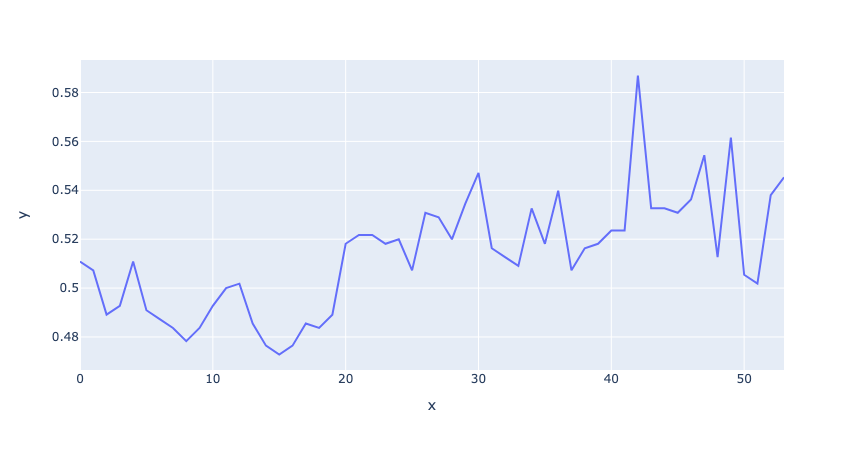

In [299]:
print(backdoorAcc)
fig = px.line(y=backdoorAcc)
fig.show()